# Customer Experience Optimization Analysis - StyleForward Retail

## Overview
This notebook analyzes customer touchpoints, transactions, and behavioral data to identify friction points in the customer experience journey. We'll uncover hidden patterns that reveal why StyleForward is losing $31.2M annually despite apparently healthy conversion metrics.

### Key Questions to Answer:
1. Where are the critical friction points causing customer abandonment?
2. How does experience differ between mobile and desktop users?
3. Why do social media channels show 0% conversion despite heavy investment?
4. What patterns exist in successful vs failed customer journeys?
5. How can we quantify the revenue impact of experience gaps?

## Section 1: Data Ingestion
Loading all necessary datasets for the customer experience analysis.

In [31]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set style for visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


In [32]:
# Load all CSV files
try:
    # Core datasets for CX analysis
    customers = pd.read_csv('https://raw.githubusercontent.com/jimcody2014/eic/refs/heads/main/customers.csv')
    touchpoints = pd.read_csv('https://raw.githubusercontent.com/jimcody2014/eic/refs/heads/main/customer_touchpoints.csv')
    stores = pd.read_csv('https://raw.githubusercontent.com/jimcody2014/eic/refs/heads/main/stores.csv')
    products = pd.read_csv('https://raw.githubusercontent.com/jimcody2014/eic/refs/heads/main/products.csv')

    print("All datasets loaded successfully!")
    print("\nDataset shapes:")
    print(f"  Customers: {customers.shape}")    
    print(f"  Customer Touchpoints: {touchpoints.shape}")
 
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please ensure all CSV files are in the current directory.")

All datasets loaded successfully!

Dataset shapes:
  Customers: (32, 13)
  Customer Touchpoints: (27, 17)


In [33]:
customers.head()

,customer_id,first_name,last_name,email,city,state,age,gender,customer_segment,acquisition_date,acquisition_channel,lifetime_value,churn_risk
0,1001,Emily,Johnson,emily.j@email.com,Austin,TX,28,0,Occasional,3/15/22,Social Media,892.50,Low
1,1002,Michael,Chen,m.chen@email.com,Dallas,TX,35,M,High-Value,1/20/21,Google,4587.30,Low
2,1003,Sarah,Williams,sarah.w@email.com,Houston,TX,42,F,Frequent,6/10/21,Email,2245.80,Medium
3,1004,James,Davis,james.d@email.com,San Antonio,TX,31,M,Occasional,2/28/23,Direct,445.60,High
4,1005,Maria,Garcia,maria.g@email.com,Austin,TX,26,F,New,1/5/24,Instagram,125.40,Medium


In [34]:
touchpoints.head()

,touchpoint_id,customer_id,session_id,touchpoint_timestamp,touchpoint_type,channel,campaign_id,referrer_source,landing_page,pages_viewed,products_viewed,cart_additions,cart_value,converted_flag,transaction_id,device_type,store_id
0,6001,1001,sess_1001_01,1/3/24 9:00,Ad Click,Instagram,101.00,instagram.com,/spring-collection,5.00,"[2001, 2002, 2005]",0,0.00,False,NaN,Mobile,NaN
1,6002,1001,sess_1001_02,1/4/24 19:30,Web Visit,Direct,NaN,direct,/home,8.00,"[2001, 2003, 2007, 2009]",2,99.98,False,NaN,Mobile,NaN
2,6003,1001,sess_1001_03,1/5/24 10:25,Web Visit,Email,103.00,email,/sale,3.00,"[2001, 2003, 2007]",3,189.97,True,4001.00,Mobile,NaN
3,6004,1003,sess_1003_01,1/7/24 14:00,Email Open,Email,103.00,gmail.com,NaN,NaN,NaN,0,0.00,False,NaN,Mobile,NaN
4,6005,1003,sess_1003_02,1/8/24 11:15,Web Visit,Email,103.00,email,/new-arrivals,4.00,"[2009, 2006]",1,149.99,True,4003.00,Desktop,NaN


### Quick Exercise (5 minutes)

1. Read in the transactions data. Name the df *transactions*.
2. Identify the number of rows and columns
3. Display the first **10** row

https://raw.githubusercontent.com/jimcody2014/eic/refs/heads/main/transactions.csv

In [35]:
# Add customer transactions
import pandas as pd
transactions = pd.read_csv("C:\\Labs\\Resources\\team-project\\transactions.csv")

In [36]:
# transactionss shape
transactions.shape


(45, 16)

In [37]:
# transactions first 10 rows
transactions.head()

,transaction_id,customer_id,order_date,channel,store_id,payment_method,card_bank,subtotal,discount_amount,tax_amount,shipping_amount,total_amount,promo_code_used,device_type,fulfillment_method,return_flag
0,4001,1001,1/5/24 10:30,Online,NaN,Credit Card,Chase,189.97,20.00,15.20,0.00,185.17,SPRING24,Mobile,Ship,False
1,4002,1001,1/12/24 14:45,Store,3002.00,Credit Cards,Citi,299.96,0.00,24.00,0.00,323.96,NaN,NaN,In-Store,False
2,4003,1003,1/8/24 11:20,Online,NaN,PayPal,NaN,149.99,15.00,11.20,5.99,151.18,WELCOME10,Desktop,Ship,False
3,4004,1003,1/15/24 16:00,Mobile App,NaN,Apple Pay,NaN,69.99,0.00,5.60,0.00,75.59,NaN,Mobile,BOPIS,False
4,4005,1002,1/7/24 13:30,Store,3001.00,credit card,NaN,79.99,0.00,6.40,0.00,86.39,NaN,NaN,In-Store,False


## Section 2: Data Cleaning
Identifying and resolving data quality issues including duplicates, missing values, incorrect data types, and inconsistencies.

### Check for Duplicates

In [38]:
# checking for duplicates
# .duplicated test to see if the entire row is a duplicate

#transactions.loc[transactions.duplicated()]
customers.loc[customers.duplicated()]

,customer_id,first_name,last_name,email,city,state,age,gender,customer_segment,acquisition_date,acquisition_channel,lifetime_value,churn_risk
30,1030,Eric,Young,eric.y@email.com,Houston,TX,46,M,Dormant,12/1/20,Email,267.90,High
31,1030,Eric,Young,eric.y@email.com,Houston,TX,46,M,Dormant,12/1/20,Email,267.90,High


In [39]:
customers.drop_duplicates(keep = 'first', inplace = True) 

# keep - which duplicate to keep, default is none!

customers.loc[customers.duplicated()]

,customer_id,first_name,last_name,email,city,state,age,gender,customer_segment,acquisition_date,acquisition_channel,lifetime_value,churn_risk


In [40]:
# Check for duplicate rows in multiple dataset
# Example of automating the process

datasets = {
    'customers': customers,
    'stores': stores,
    'products': products
}

print("Checking for duplicate rows:")
print("="*40)
for name, df in datasets.items():
    duplicates = df.duplicated().sum()
    print(f"{name}: {duplicates} duplicate rows")
    
    # Check for duplicates on key columns
    if name == 'stores':
        dup_store_ids = df['store_id'].duplicated().sum()
        print(f"  - Duplicate store_ids: {dup_store_ids}")
    elif name == 'transactions':
        dup_transaction_ids = df['transaction_id'].duplicated().sum()
        print(f"  - Duplicate transaction_ids: {dup_transaction_ids}")
    elif name == 'customers':
        dup_customer_ids = df['customer_id'].duplicated().sum()
        print(f"  - Duplicate customer_ids: {dup_customer_ids}")

# Remove any duplicates found
for name, df in datasets.items():
    before = len(df)
    df.drop_duplicates(inplace=True)
    after = len(df)
    if before != after:
        print(f"\nRemoved {before-after} duplicates from {name}")

Checking for duplicate rows:
customers: 0 duplicate rows
  - Duplicate customer_ids: 0
stores: 0 duplicate rows
  - Duplicate store_ids: 0
products: 0 duplicate rows


### Find and Handle Missing Values

### Examine Customers

In [41]:
# Just listing the columns and how many rows 
# for each have a missing value.

customers.isnull().sum()

customer_id            0
first_name             0
last_name              0
email                  0
city                   0
state                  2
age                    0
gender                 0
customer_segment       0
acquisition_date       0
acquisition_channel    0
lifetime_value         1
churn_risk             0
dtype: int64

In [42]:
customers_null = customers.isna().mean().round(4) * 100

customers_null.sort_values(ascending=False).head()

state            6.67
lifetime_value   3.33
last_name        0.00
first_name       0.00
customer_id      0.00
dtype: float64

<Axes: >

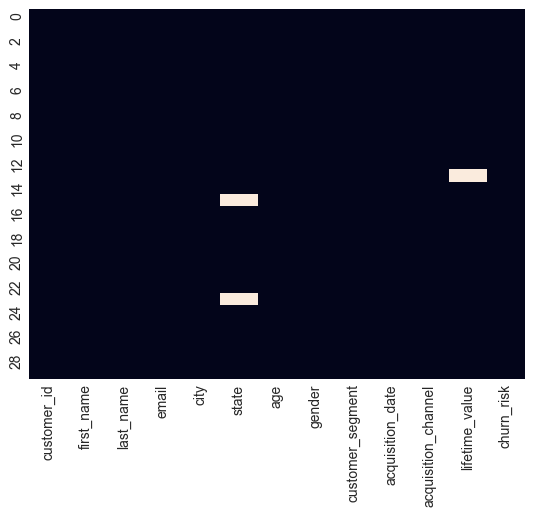

In [43]:
# Plotting missing values

sns.heatmap(customers.isnull(), cbar=False)

In [44]:
a = customers['lifetime_value'].describe()
b = customers['lifetime_value'].median()
c = customers['lifetime_value'].mode()
print(a)
print()
print(f'Median: {b}')
print()
print(f'Mode: {c}')

#if len(c) == 1:
#    print(f'Mode: {c.iloc[0]}')
#else:
#    print(f'Multiple modes ({len(c)} values). Example first mode: {c.iloc[0]}')
#    print('All modes:', c.tolist())

count     29.00
mean    2031.34
std     1907.99
min      125.40
25%      423.50
50%     1789.30
75%     3567.20
max     6234.90
Name: lifetime_value, dtype: float64

Median: 1789.3

Mode: 0     125.40
1     156.80
2     189.90
3     198.70
4     215.60
5     234.80
6     267.90
7     423.50
8     445.60
9     534.80
10    623.70
11    678.40
12    756.30
13    892.50
14   1789.30
15   1876.30
16   2156.90
17   2234.70
18   2245.80
19   2345.60
20   2678.90
21   3567.20
22   3892.40
23   4123.60
24   4587.30
25   4876.50
26   5123.40
27   5432.10
28   6234.90
Name: lifetime_value, dtype: float64


In [45]:
# Fill the lifetime value with the mean for the column

customers.lifetime_value.fillna(customers.lifetime_value.mean(),inplace=True)

# Check missing values in customers
print("\nMissing Values Analysis - Customers")
print("="*50)
missing_customers = customers.isnull().sum()
missing_pct_cust = (missing_customers / len(customers)) * 100
missing_cust_df = pd.DataFrame({
    'Missing_Count': missing_customers,
    'Percentage': missing_pct_cust
})
print(missing_cust_df[missing_cust_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))


Missing Values Analysis - Customers
       Missing_Count  Percentage
state              2        6.67


In [46]:
# Check for missing values in touchpoints
print("Missing Values Analysis - touchpoints")
print("="*50)
missing_touchpoints = touchpoints.isnull().sum()
missing_pct = (missing_touchpoints / len(touchpoints)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_touchpoints,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))


Missing Values Analysis - touchpoints
                 Missing_Count  Percentage
store_id                    22       81.48
campaign_id                 12       44.44
pages_viewed                 8       29.63
landing_page                 8       29.63
transaction_id               8       29.63
products_viewed              8       29.63
referrer_source              5       18.52
device_type                  5       18.52


In [48]:
# Handle missing values strategically
print("Handling Missing Values:")
print("="*40)

# For touchpoints dataset
# Fill missing campaign_id with -1 (indicates organic/direct traffic)
touchpoints['campaign_id'].fillna(-1, inplace=True)
print("Filled missing campaign_id with -1 (organic traffic indicator)")

# Fill missing store_id with -1 (indicates online interaction)
touchpoints['store_id'].fillna(-1, inplace=True)
print("Filled missing store_id with -1 (online interaction)")

# Fill missing transaction_id with -1 (indicates no conversion)
touchpoints['transaction_id'].fillna(-1, inplace=True)
print("Filled missing transaction_id with -1 (no conversion)")

# For customers dataset
# Fill missing state with TX
customers['state'].fillna('TX', inplace=True)
print("Filled missing state in customers with TX")


print("\nMissing values handled successfully!")

Handling Missing Values:
Filled missing campaign_id with -1 (organic traffic indicator)
Filled missing store_id with -1 (online interaction)
Filled missing transaction_id with -1 (no conversion)
Filled missing state in customers with TX

Missing values handled successfully!


### Quick Exercise (10 minutes)

1. Does transactions have any duplicates?
2. Does it have any missing values? Which variables should you populate with imputed data?
3. Populate missing shipping amounts with the mean of the column.
4. Populate missing store ids with -1 to indicate an online.
5. Populate missing promo codes with 'None'.

In [8]:
# Check duplicates in transactions
transactions.loc[transactions.duplicated()]

,transaction_id,customer_id,order_date,channel,store_id,payment_method,card_bank,subtotal,discount_amount,tax_amount,shipping_amount,total_amount,promo_code_used,device_type,fulfillment_method,return_flag


In [39]:
# Check missing values in transactions
transactions.isnull().sum()

transaction_id         0
customer_id            0
order_date             0
channel                0
store_id              29
payment_method         0
card_bank             41
subtotal               0
discount_amount        0
tax_amount             0
shipping_amount        3
total_amount           0
promo_code_used       26
device_type           16
fulfillment_method     0
return_flag            0
dtype: int64

In [41]:
# Populate missing shipping_value rows with the mean.
transactions.shipping_amount.fillna(transactions.shipping_amount.mean(),inplace=True)


In [42]:
# Fill missing store_id with -1 (online transaction)
transactions['store_id'].fillna(-1, inplace=True)
print("Filled missing store_id with -1 (online transaction) ")


Filled missing store_id with -1 (online transaction) 


In [43]:
# Fill missing promo_code with 'NONE'
transactions['promo_code_used'].fillna('NONE', inplace=True)
print("Filled missing promo_code_used with 'NONE' ")


Filled missing promo_code_used with 'NONE' 


### Data Type Corrections

In [44]:
# Check current data types
touchpoints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   touchpoint_id         27 non-null     int64  
 1   customer_id           27 non-null     int64  
 2   session_id            27 non-null     object 
 3   touchpoint_timestamp  27 non-null     object 
 4   touchpoint_type       27 non-null     object 
 5   channel               27 non-null     object 
 6   campaign_id           27 non-null     float64
 7   referrer_source       22 non-null     object 
 8   landing_page          19 non-null     object 
 9   pages_viewed          19 non-null     float64
 10  products_viewed       19 non-null     object 
 11  cart_additions        27 non-null     int64  
 12  cart_value            27 non-null     float64
 13  converted_flag        27 non-null     bool   
 14  transaction_id        27 non-null     float64
 15  device_type           22 

In [45]:
# Convert store_id from float to string (it's actually a store identifier, not a numeric value)

# Convert to categorical
touchpoints['store_id'] = touchpoints['store_id'].astype('string')

print("Converted store_id to string type")
print(f"New data type: {touchpoints['store_id'].dtype}")

# Convert campaign_id to string as well
touchpoints['campaign_id'] = touchpoints['campaign_id'].astype('string')
print("Converted campaign_id to string type")

Converted store_id to string type
New data type: string
Converted campaign_id to string type


In [46]:
# change to numeric example
# vaccines['series_complete_pop_pct'] = pd.to_numeric(vaccines['series_complete_pop_pct']).astype(int)

### Rename Columns for Clarity

In [48]:
# Rename columns for better clarity
print("Renaming columns for clarity...")
print("="*40)

# Rename in touchpoints
touchpoints.rename(columns={
    'converted_flag': 'conversion_status',
    'touchpoint_timestamp': 'interaction_datetime'
}, inplace=True)

print(" Renamed touchpoints columns:")
print("  - converted_flag → conversion_status")
print("  - touchpoint_timestamp → interaction_datetime")

print("\nNew column names:")
print(f"Touchpoints: {list(touchpoints.columns[:5])}...")


Renaming columns for clarity...
 Renamed touchpoints columns:
  - converted_flag → conversion_status
  - touchpoint_timestamp → interaction_datetime

New column names:
Touchpoints: ['touchpoint_id', 'customer_id', 'session_id', 'interaction_datetime', 'touchpoint_type']...


### Quick Exercise (5 minutes)

1. Change tranactions store_id to a category.
2. Rename return_flag to was_returned.

In [53]:
# Check current data types
transactions.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      45 non-null     int64  
 1   customer_id         45 non-null     int64  
 2   order_date          45 non-null     object 
 3   channel             45 non-null     object 
 4   store_id            45 non-null     string 
 5   payment_method      45 non-null     object 
 6   card_bank           4 non-null      object 
 7   subtotal            45 non-null     float64
 8   discount_amount     45 non-null     float64
 9   tax_amount          45 non-null     float64
 10  shipping_amount     45 non-null     float64
 11  total_amount        45 non-null     float64
 12  promo_code_used     45 non-null     object 
 13  device_type         29 non-null     object 
 14  fulfillment_method  45 non-null     object 
 15  was_returned        45 non-null     bool   
dtypes: bool(1)

In [52]:
# Change store_id to a category data type
transactions['store_id'] = transactions['store_id'].astype('string')

print("Converted store_id to string type")
print(f"New data type: {transactions['store_id'].dtype}")


Converted store_id to string type
New data type: string


In [51]:
# Rename in transactions
transactions.rename(columns={
    'return_flag': 'was_returned'
}, inplace=True)


### Categorical Data Analysis and Visualization

### Examine touchpoints

In [54]:
# Analyze categorical columns: channel, device_type, touchpoint_type
categorical_cols = ['channel', 'device_type', 'touchpoint_type']

print("Categorical Data Analysis")
print("="*50)

for col in categorical_cols:
    print(f"\n{col.upper()}:")
    print(f"  Unique values: {touchpoints[col].nunique()}")
    print(f"  Unique list: {touchpoints[col].unique().tolist()}")
    print(f"\n  Value counts:")
    print(touchpoints[col].value_counts())

Categorical Data Analysis

CHANNEL:
  Unique values: 7
  Unique list: ['Instagram', 'Direct', 'Email', 'TikTok', 'Walk-in', 'Facebook', 'Google']

  Value counts:
channel
Direct       7
Email        6
Walk-in      5
Google       4
Instagram    2
TikTok       2
Facebook     1
Name: count, dtype: int64

DEVICE_TYPE:
  Unique values: 2
  Unique list: ['Mobile', 'Desktop', nan]

  Value counts:
device_type
Mobile     14
Desktop     8
Name: count, dtype: int64

TOUCHPOINT_TYPE:
  Unique values: 5
  Unique list: ['Ad Click', 'Web Visit', 'Email Open', 'Store Visit', 'Ad View']

  Value counts:
touchpoint_type
Web Visit      14
Store Visit     5
Ad Click        4
Email Open      3
Ad View         1
Name: count, dtype: int64


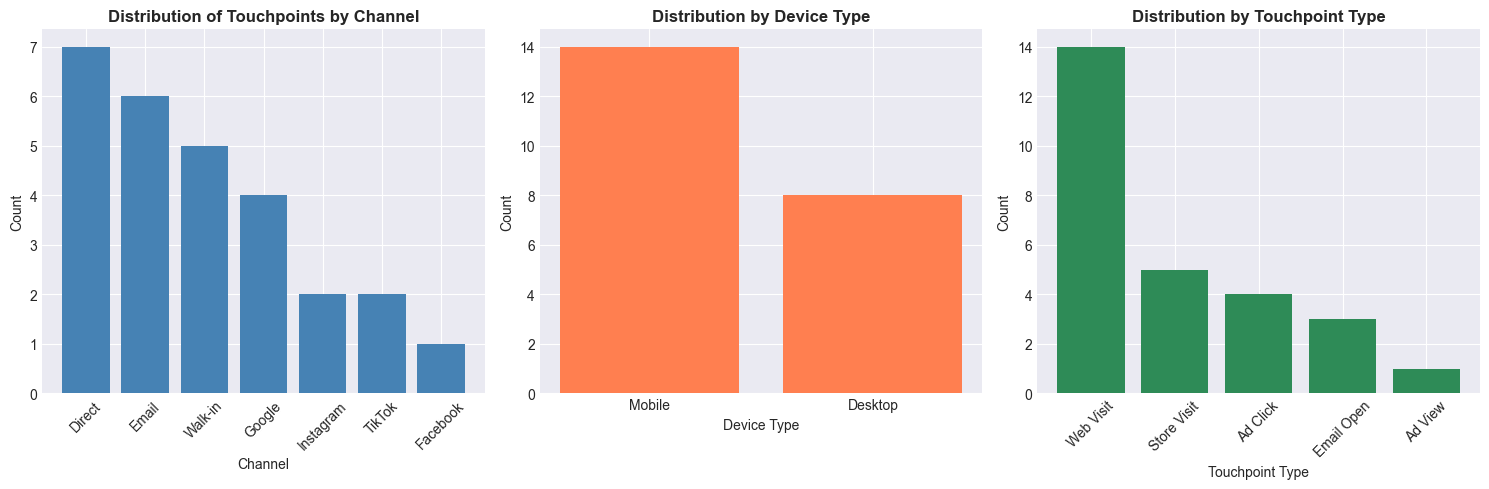

In [55]:
# Create bar charts for categorical variables
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Channel distribution
channel_counts = touchpoints['channel'].value_counts()
axes[0].bar(channel_counts.index, channel_counts.values, color='steelblue')
axes[0].set_title('Distribution of Touchpoints by Channel', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Channel')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Device type distribution
device_counts = touchpoints['device_type'].value_counts()
axes[1].bar(device_counts.index, device_counts.values, color='coral')
axes[1].set_title('Distribution by Device Type', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Device Type')
axes[1].set_ylabel('Count')

# Touchpoint type distribution
touchpoint_counts = touchpoints['touchpoint_type'].value_counts()
axes[2].bar(touchpoint_counts.index, touchpoint_counts.values, color='seagreen')
axes[2].set_title('Distribution by Touchpoint Type', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Touchpoint Type')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Bar Charts for customers

<Axes: xlabel='gender', ylabel='count'>

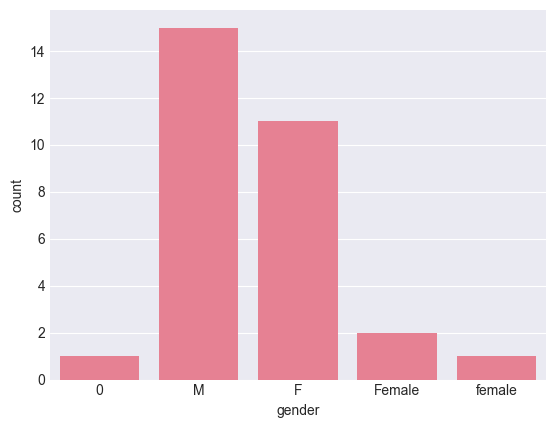

In [56]:
sns.countplot(x='gender', data=customers)

### Fix Data Inconsistencies

In [57]:
# Change/Fix some of the data values

customers['gender'] = customers['gender'].replace({'M':'Male', 'F':'Female'})


In [58]:
# Inconsistent capitalization
# Apply a function along an axis of the DataFrame.

customers['gender'] = customers['gender'].apply(lambda x:x.lower())

In [59]:
x = customers.loc[customers.gender == 'unknown/invalid','gender']
y = customers.loc[customers.gender == '0','gender']
print(x)
print(y)

Series([], Name: gender, dtype: object)
0    0
Name: gender, dtype: object


<Axes: xlabel='gender', ylabel='count'>

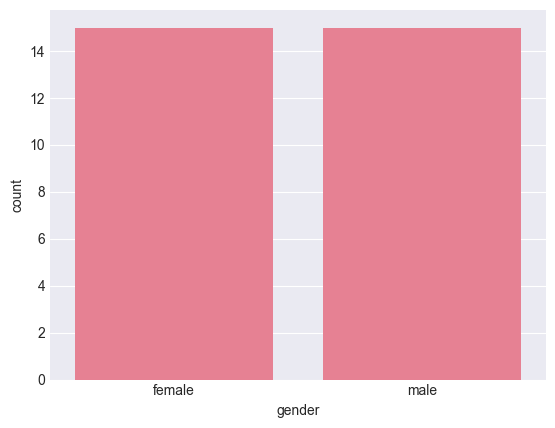

In [60]:
customers['gender'] = customers['gender'].replace({'0':'female'})
sns.countplot(x='gender', data=customers)

In [61]:
# Check for inconsistencies in categorical data
print("Checking for Data Inconsistencies")
print("="*50)

# Check channel values for inconsistencies
print("\nChannel values (checking for case inconsistencies):")
channels = touchpoints['channel'].str.lower().value_counts()
print(channels)

# Standardize channel names (ensure consistent casing)
touchpoints['channel'] = touchpoints['channel'].str.title()
print("\n✓ Standardized channel names to Title Case")

# Check for inconsistent device type values
print("\nDevice Type values:")
print(touchpoints['device_type'].value_counts())

# Fix any None/NaN values in device_type
touchpoints['device_type'].fillna('Unknown', inplace=True)
print("✓ Filled missing device_type with 'Unknown'")

# Check referrer_source for cleanup
print("\nReferrer source values (sample):")
print(touchpoints['referrer_source'].value_counts().head())

# Standardize referrer_source
touchpoints['referrer_source'] = touchpoints['referrer_source'].str.lower().str.strip()
print("✓ Standardized referrer_source to lowercase and removed whitespace")

Checking for Data Inconsistencies

Channel values (checking for case inconsistencies):
channel
direct       7
email        6
walk-in      5
google       4
instagram    2
tiktok       2
facebook     1
Name: count, dtype: int64

✓ Standardized channel names to Title Case

Device Type values:
device_type
Mobile     14
Desktop     8
Name: count, dtype: int64
✓ Filled missing device_type with 'Unknown'

Referrer source values (sample):
referrer_source
direct           7
google.com       4
email            3
instagram.com    2
gmail.com        2
Name: count, dtype: int64
✓ Standardized referrer_source to lowercase and removed whitespace


### Numeric Data Analysis and Visualization

In [62]:
# Analyze numeric columns
numeric_cols = ['pages_viewed', 'cart_additions', 'cart_value']

print("Numeric Data Statistics")
print("="*50)
print(touchpoints[numeric_cols].describe())

Numeric Data Statistics
       pages_viewed  cart_additions  cart_value
count         19.00           27.00       27.00
mean           6.74            1.22      115.17
std            4.74            1.22      144.20
min            2.00            0.00        0.00
25%            3.00            0.00        0.00
50%            5.00            1.00       89.99
75%            9.00            2.00      169.98
max           18.00            3.00      629.97


### Let's talk about histograms for a minute!

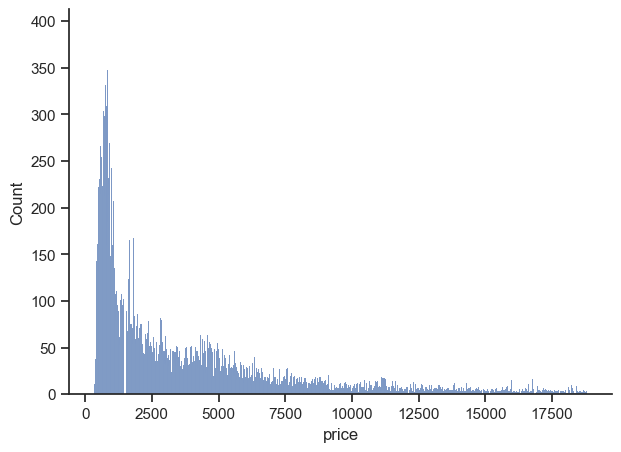

In [63]:
# Change the bin size to get a picture that is helpful.

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

diamonds = sns.load_dataset("diamonds")

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.histplot(data=diamonds, x='price', binwidth = 10)
plt.show()

### Histgrams for project data

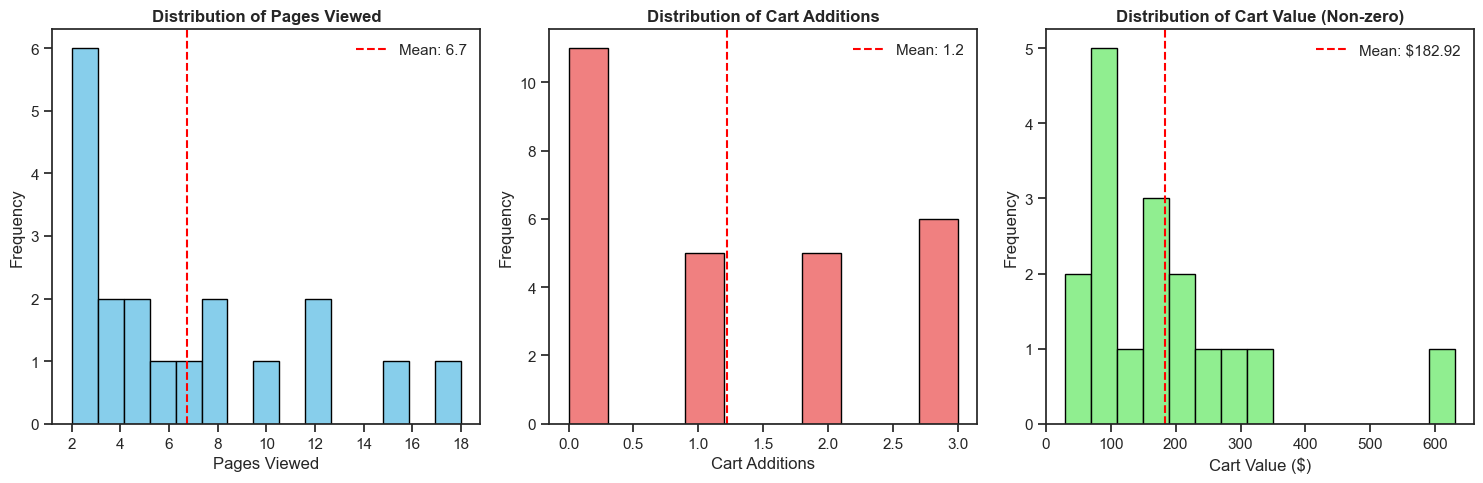

In [64]:
# Create histograms for numeric columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Pages viewed histogram
axes[0].hist(touchpoints['pages_viewed'].dropna(), bins=15, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Pages Viewed', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Pages Viewed')
axes[0].set_ylabel('Frequency')
axes[0].axvline(touchpoints['pages_viewed'].mean(), color='red', linestyle='--', label=f'Mean: {touchpoints["pages_viewed"].mean():.1f}')
axes[0].legend()

# Cart additions histogram
axes[1].hist(touchpoints['cart_additions'], bins=10, color='lightcoral', edgecolor='black')
axes[1].set_title('Distribution of Cart Additions', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Cart Additions')
axes[1].set_ylabel('Frequency')
axes[1].axvline(touchpoints['cart_additions'].mean(), color='red', linestyle='--', label=f'Mean: {touchpoints["cart_additions"].mean():.1f}')
axes[1].legend()

# Cart value histogram (excluding zeros)
cart_values_nonzero = touchpoints[touchpoints['cart_value'] > 0]['cart_value']
axes[2].hist(cart_values_nonzero, bins=15, color='lightgreen', edgecolor='black')
axes[2].set_title('Distribution of Cart Value (Non-zero)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Cart Value ($)')
axes[2].set_ylabel('Frequency')
axes[2].axvline(cart_values_nonzero.mean(), color='red', linestyle='--', label=f'Mean: ${cart_values_nonzero.mean():.2f}')
axes[2].legend()

plt.tight_layout()
plt.show()

### Boxplots for project data

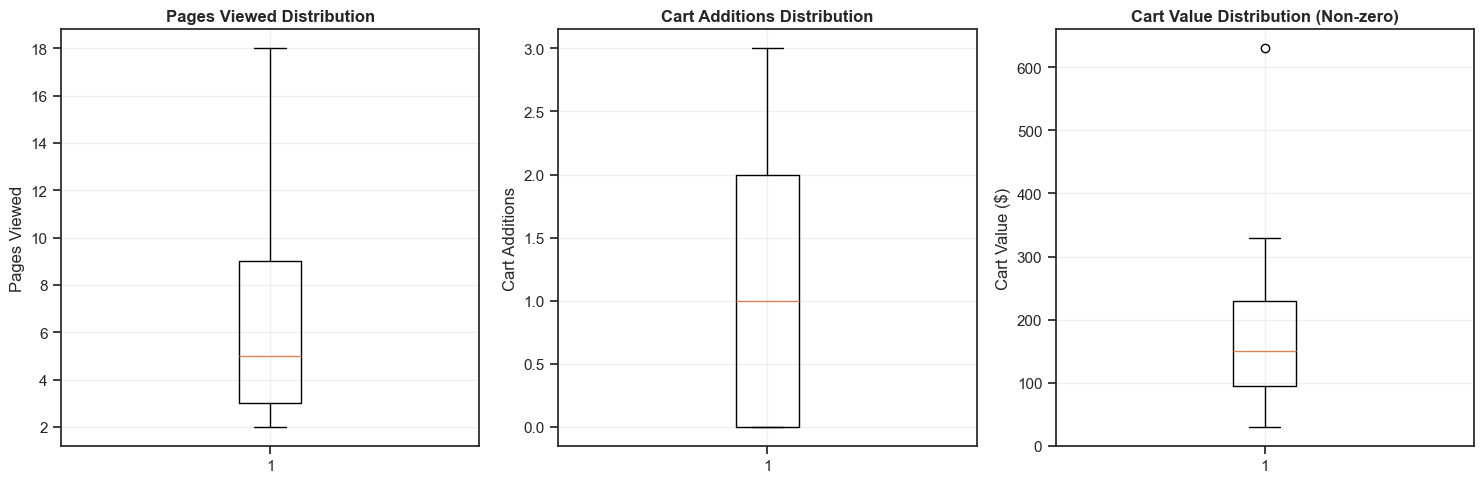


Found 1 outliers in cart_value (using IQR method)


In [65]:
# Create boxplots for numeric columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Pages viewed boxplot
axes[0].boxplot(touchpoints['pages_viewed'].dropna(), vert=True)
axes[0].set_title('Pages Viewed Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Pages Viewed')
axes[0].grid(True, alpha=0.3)

# Cart additions boxplot
axes[1].boxplot(touchpoints['cart_additions'].dropna(), vert=True)
axes[1].set_title('Cart Additions Distribution', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cart Additions')
axes[1].grid(True, alpha=0.3)

# Cart value boxplot (non-zero)
axes[2].boxplot(cart_values_nonzero, vert=True)
axes[2].set_title('Cart Value Distribution (Non-zero)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Cart Value ($)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify outliers
Q1 = touchpoints['cart_value'].quantile(0.25)
Q3 = touchpoints['cart_value'].quantile(0.75)
IQR = Q3 - Q1
outliers = touchpoints[(touchpoints['cart_value'] < Q1 - 1.5*IQR) | (touchpoints['cart_value'] > Q3 + 1.5*IQR)]
print(f"\nFound {len(outliers)} outliers in cart_value (using IQR method)")

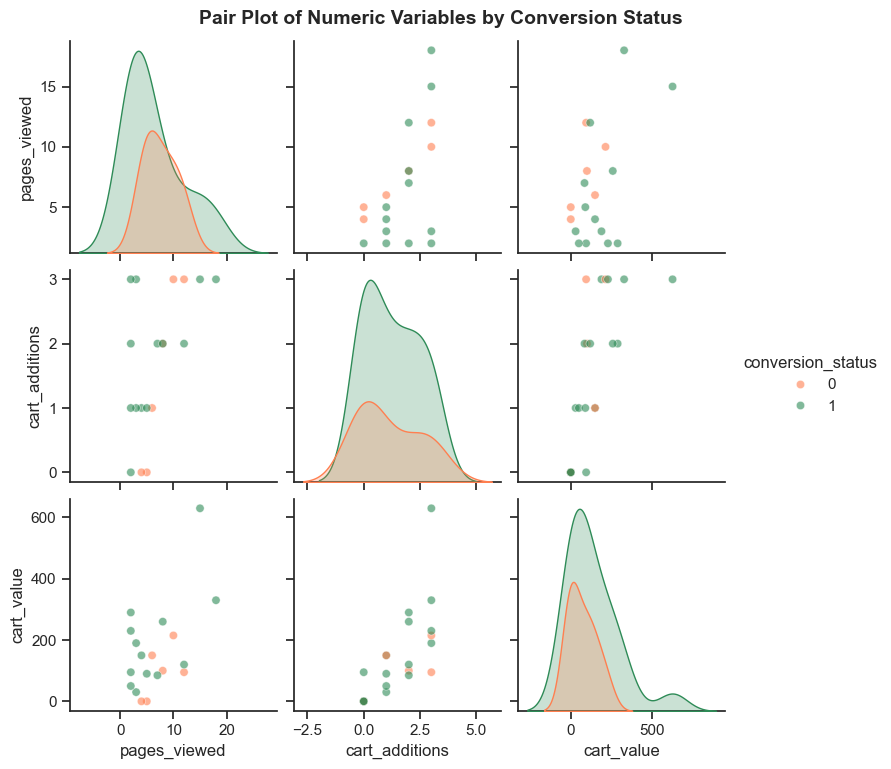

Pair plot shows relationships between:
- Pages viewed
- Cart additions
- Cart value
- Colored by conversion status (0=No conversion, 1=Converted)


In [66]:
# Create pair plot for numeric variables
numeric_data = touchpoints[['pages_viewed', 'cart_additions', 'cart_value', 'conversion_status']].copy()
numeric_data['conversion_status'] = numeric_data['conversion_status'].astype(int)

# Create pairplot
fig = sns.pairplot(numeric_data, hue='conversion_status', 
                   palette={0: 'coral', 1: 'seagreen'},
                   diag_kind='kde',
                   plot_kws={'alpha': 0.6})
fig.fig.suptitle('Pair Plot of Numeric Variables by Conversion Status', y=1.02, fontsize=14, fontweight='bold')
plt.show()

print("Pair plot shows relationships between:")
print("- Pages viewed")
print("- Cart additions")
print("- Cart value")
print("- Colored by conversion status (0=No conversion, 1=Converted)")

### Quick Exercise (30 minutes)

1. Explore the transactions data.
2. Look at the categorical data.
3. Look at the numeric data.
4. Make sure every column is examined.

In [67]:
# Just a function to organize the data

def split_columns(df: pd.DataFrame) -> dict:
    out = {
        "numeric":   df.select_dtypes(include=[np.number]).columns.tolist(),
        "integer":   df.select_dtypes(include=[np.integer]).columns.tolist(),
        "float":     df.select_dtypes(include=[np.floating]).columns.tolist(),
        "boolean":   df.select_dtypes(include=['bool', 'boolean']).columns.tolist(),
        "object":    df.select_dtypes(include=['object', 'string']).columns.tolist(),
        "category":  df.select_dtypes(include=['category']).columns.tolist(),
        "datetime":  df.select_dtypes(include=['datetime', 'datetimetz']).columns.tolist(),
    }
    return out


In [68]:
# Add the df name that the function is applied to

#########
# After transactions is added to the notebook.  Uncomment the lines below.
#########

cols = split_columns(transactions)
numeric_cols = cols['numeric']
integer_cols = cols['integer']
float_cols = cols['float']
boolean_cols = cols['boolean']
object_cols = cols['object']
category_cols = cols['category']
datetime_cols = cols['datetime']

# print(f'Numeric: {numeric_cols}')
# print(f'Integer: {integer_cols}')
# print(f'Float: {float_cols}')
# print(f'Boolean: {boolean_cols}')
# print(f'Object: {object_cols}')
# print(f'Category: {category_cols}')
# print(f'Datetime: {datetime_cols}')

### Exercie Code

## Section 3: Data Transformation
Creating derived features and transforming data to enable deeper analysis of customer experience patterns.

### Transformation Planning

To uncover the hidden friction points in the customer journey, we need to create several derived features:

1. **Time-based features**: Extract hour, day of week, and time of day from timestamps to identify temporal patterns
2. **Journey complexity metrics**: Calculate touchpoints per customer, channels used, devices used
3. **Conversion funnel stages**: Map touchpoints to funnel stages (awareness, consideration, purchase)
4. **Conversion and Abandoment indicators**: Flags abandoned carts and the abandoment value
5. **Friction indicators**: Calculate abandonment rates, time between touchpoints

In [69]:
# 1. Parse and extract time-based features
print("Creating Time-Based Features")
print("="*50)

# Parse the interaction datetime
touchpoints['interaction_datetime_parsed'] = pd.to_datetime(touchpoints['interaction_datetime'], format='%m/%d/%y %H:%M', errors='coerce')

# Extract time components
touchpoints['hour'] = touchpoints['interaction_datetime_parsed'].dt.hour
touchpoints['day_of_week'] = touchpoints['interaction_datetime_parsed'].dt.dayofweek
touchpoints['day_name'] = touchpoints['interaction_datetime_parsed'].dt.day_name()

# Create time of day categories
def categorize_time_of_day(hour):
    if pd.isna(hour):
        return 'Unknown'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

touchpoints['time_of_day'] = touchpoints['hour'].apply(categorize_time_of_day)

print(f"Created time-based features: hour, day_of_week, day_name, time_of_day")
print(f"\nTime of day distribution:")
print(touchpoints['time_of_day'].value_counts())

Creating Time-Based Features
Created time-based features: hour, day_of_week, day_name, time_of_day

Time of day distribution:
time_of_day
Morning      11
Afternoon    11
Evening       5
Name: count, dtype: int64


In [70]:
touchpoints.head()

,touchpoint_id,customer_id,session_id,interaction_datetime,touchpoint_type,channel,campaign_id,referrer_source,landing_page,pages_viewed,products_viewed,cart_additions,cart_value,conversion_status,transaction_id,device_type,store_id,interaction_datetime_parsed,hour,day_of_week,day_name,time_of_day
0,6001,1001,sess_1001_01,1/3/24 9:00,Ad Click,Instagram,101.0,instagram.com,/spring-collection,5.00,"[2001, 2002, 2005]",0,0.00,False,-1.00,Mobile,-1.0,2024-01-03 09:00:00,9,2,Wednesday,Morning
1,6002,1001,sess_1001_02,1/4/24 19:30,Web Visit,Direct,-1.0,direct,/home,8.00,"[2001, 2003, 2007, 2009]",2,99.98,False,-1.00,Mobile,-1.0,2024-01-04 19:30:00,19,3,Thursday,Evening
2,6003,1001,sess_1001_03,1/5/24 10:25,Web Visit,Email,103.0,email,/sale,3.00,"[2001, 2003, 2007]",3,189.97,True,4001.00,Mobile,-1.0,2024-01-05 10:25:00,10,4,Friday,Morning
3,6004,1003,sess_1003_01,1/7/24 14:00,Email Open,Email,103.0,gmail.com,NaN,NaN,NaN,0,0.00,False,-1.00,Mobile,-1.0,2024-01-07 14:00:00,14,6,Sunday,Afternoon
4,6005,1003,sess_1003_02,1/8/24 11:15,Web Visit,Email,103.0,email,/new-arrivals,4.00,"[2009, 2006]",1,149.99,True,4003.00,Desktop,-1.0,2024-01-08 11:15:00,11,0,Monday,Morning


In [71]:
# 2. Calculate journey complexity metrics
print("Calculating Journey Complexity Metrics")
print("="*50)

# Customer journey aggregations
customer_journey_metrics = touchpoints.groupby('customer_id').agg({
    'touchpoint_id': 'count',
    'channel': lambda x: x.nunique(),
    'device_type': lambda x: x.nunique(),
    'conversion_status': lambda x: x.any(),
    'cart_value': 'sum',
    'pages_viewed': 'sum',
    'cart_additions': 'sum'
}).reset_index()

customer_journey_metrics.columns = ['customer_id', 'total_touchpoints', 'channels_used', 
                                    'devices_used', 'converted', 'total_cart_value',
                                    'total_pages_viewed', 'total_cart_additions']

# Add flags for multi-channel and multi-device
customer_journey_metrics['is_multichannel'] = customer_journey_metrics['channels_used'] > 1
customer_journey_metrics['is_multidevice'] = customer_journey_metrics['devices_used'] > 1

print(f"Created journey metrics for {len(customer_journey_metrics)} customers")
print(f"\nJourney complexity summary:")
print(f"  Multi-channel customers: {customer_journey_metrics['is_multichannel'].sum()} ({customer_journey_metrics['is_multichannel'].mean()*100:.1f}%)")
print(f"  Multi-device customers: {customer_journey_metrics['is_multidevice'].sum()} ({customer_journey_metrics['is_multidevice'].mean()*100:.1f}%)")
print(f"  Average touchpoints per customer: {customer_journey_metrics['total_touchpoints'].mean():.1f}")

Calculating Journey Complexity Metrics
Created journey metrics for 19 customers

Journey complexity summary:
  Multi-channel customers: 4 (21.1%)
  Multi-device customers: 2 (10.5%)
  Average touchpoints per customer: 1.4


In [74]:
# 3. Map touchpoints to funnel stages
print("Mapping Touchpoints to Funnel Stages")
print("="*50)

def assign_funnel_stage(row):
    """Assign each touchpoint to a funnel stage based on behavior"""
    if row['conversion_status'] == True:
        return 'Purchase'
    elif row['cart_additions'] > 0:
        return 'Consideration'
    else:
        return 'Awareness'

touchpoints['funnel_stage'] = touchpoints.apply(assign_funnel_stage, axis=1)

print("Assigned funnel stages to all touchpoints")
print("\nFunnel stage distribution:")
funnel_dist = touchpoints['funnel_stage'].value_counts()
for stage in ['Awareness', 'Consideration', 'Purchase']:
    count = funnel_dist.get(stage, 0)
    pct = (count / len(touchpoints)) * 100
    print(f"  {stage}: {count} ({pct:.1f}%)")

Mapping Touchpoints to Funnel Stages
Assigned funnel stages to all touchpoints

Funnel stage distribution:
  Awareness: 4 (14.8%)
  Consideration: 4 (14.8%)
  Purchase: 19 (70.4%)


In [73]:
# 4. Create conversion and abandonment indicators
print("Creating Conversion and Abandonment Indicators")
print("="*50)

# Flag abandoned carts
touchpoints['cart_abandoned'] = (touchpoints['cart_additions'] > 0) & (touchpoints['conversion_status'] == False)

# Calculate abandonment value
touchpoints['abandonment_value'] = touchpoints.apply(
    lambda x: x['cart_value'] if x['cart_abandoned'] else 0, axis=1
)

total_abandoned_value = touchpoints['abandonment_value'].sum()
print(f"✓ Identified cart abandonment patterns")
print(f"\nAbandonment metrics:")
print(f"  Abandoned carts: {touchpoints['cart_abandoned'].sum()}")
print(f"  Total abandoned value: ${total_abandoned_value:,.2f}")
print(f"  Average abandoned cart value: ${touchpoints[touchpoints['cart_abandoned']]['cart_value'].mean():.2f}")

Creating Conversion and Abandonment Indicators
✓ Identified cart abandonment patterns

Abandonment metrics:
  Abandoned carts: 4
  Total abandoned value: $559.91
  Average abandoned cart value: $139.98


In [75]:
# 5. Create customer value segments
print("Creating Customer Value Segments")
print("="*50)

# Merge customer data with journey metrics
customers_enhanced = customers.merge(customer_journey_metrics, on='customer_id', how='left')

# Create value tiers based on lifetime value
def assign_value_tier(ltv):
    if pd.isna(ltv) or ltv == 0:
        return 'No Value'
    elif ltv < 500:
        return 'Low Value'
    elif ltv < 1500:
        return 'Medium Value'
    else:
        return 'High Value'

customers_enhanced['value_tier'] = customers_enhanced['lifetime_value'].apply(assign_value_tier)

print("✓ Created customer value tiers")
print("\nValue tier distribution:")
print(customers_enhanced['value_tier'].value_counts())

# Calculate metrics by value tier
print("\nMetrics by value tier:")
tier_metrics = customers_enhanced.groupby('value_tier').agg({
    'total_touchpoints': 'mean',
    'is_multichannel': 'mean',
    'is_multidevice': 'mean'
})
print(tier_metrics)

Creating Customer Value Segments
✓ Created customer value tiers

Value tier distribution:
value_tier
High Value      16
Low Value        9
Medium Value     5
Name: count, dtype: int64

Metrics by value tier:
              total_touchpoints is_multichannel is_multidevice
value_tier                                                    
High Value                 1.45            0.18           0.18
Low Value                  1.25            0.25           0.00
Medium Value               1.50            0.25           0.00


In [76]:
# 6. Create channel attribution features
print("Creating Channel Attribution Features")
print("="*50)

# Identify first and last touch channels for each customer
customer_touchpoints = touchpoints.sort_values(['customer_id', 'interaction_datetime_parsed'])

first_touch = customer_touchpoints.groupby('customer_id').first()[['channel']].rename(columns={'channel': 'first_touch_channel'})
last_touch = customer_touchpoints.groupby('customer_id').last()[['channel']].rename(columns={'channel': 'last_touch_channel'})

# Merge attribution data
attribution_df = first_touch.merge(last_touch, on='customer_id')
attribution_df['channel_switch'] = attribution_df['first_touch_channel'] != attribution_df['last_touch_channel']

print(f"Created attribution features")
print(f"\nChannel switching:")
print(f"  Customers who switched channels: {attribution_df['channel_switch'].sum()} ({attribution_df['channel_switch'].mean()*100:.1f}%)")

# Most common channel paths
print("\nTop channel paths (first → last):")
channel_paths = attribution_df[attribution_df['channel_switch']].groupby(['first_touch_channel', 'last_touch_channel']).size().sort_values(ascending=False).head()
print(channel_paths)

Creating Channel Attribution Features
Created attribution features

Channel switching:
  Customers who switched channels: 4 (21.1%)

Top channel paths (first → last):
first_touch_channel  last_touch_channel
Facebook             Direct                1
Instagram            Direct                1
                     Email                 1
Tiktok               Direct                1
dtype: int64


### Quick Exercise (30 minutes)

Every team project will need to use the tranasctions data.  Based on the needs of your team project, work with your partner(s) to determine if there are any transformations of transactions that will be required.

Code the requirement.




In [ ]:
# 2. Calculate journey complexity metrics
print("Calculating Journey Complexity Metrics")
print("="*50)

# Customer journey aggregations
customer_journey_metrics = transactions.groupby('customer_id').agg({
    'transaction_id': 'count',
    'channel': lambda x: x.nunique(),
    'device_type': lambda x: x.nunique(),
    'conversion_status': lambda x: x.any(),
    'cart_value': 'sum',
    'pages_viewed': 'sum',
    'cart_additions': 'sum'
}).reset_index()

customer_journey_metrics.columns = ['customer_id', 'total_touchpoints', 'channels_used', 
                                    'devices_used', 'converted', 'total_cart_value',
                                    'total_pages_viewed', 'total_cart_additions']

# Add flags for multi-channel and multi-device
customer_journey_metrics['is_multichannel'] = customer_journey_metrics['channels_used'] > 1
customer_journey_metrics['is_multidevice'] = customer_journey_metrics['devices_used'] > 1

print(f"Created journey metrics for {len(customer_journey_metrics)} customers")
print(f"\nJourney complexity summary:")
print(f"  Multi-channel customers: {customer_journey_metrics['is_multichannel'].sum()} ({customer_journey_metrics['is_multichannel'].mean()*100:.1f}%)")
print(f"  Multi-device customers: {customer_journey_metrics['is_multidevice'].sum()} ({customer_journey_metrics['is_multidevice'].mean()*100:.1f}%)")
print(f"  Average touchpoints per customer: {customer_journey_metrics['total_touchpoints'].mean():.1f}")

## Section 4: Descriptive Data Analysis
Comprehensive analysis of customer experience metrics to understand current state performance.


### Analysis Plan for Descriptive Analysis

In this section, we will:
1. **Calculate overall conversion metrics** - Understand baseline performance
2. **Analyze channel performance** - Identify which channels drive conversions
3. **Examine device-specific behaviors** - Quantify mobile vs desktop experience gaps
4. **Study customer segment patterns** - Understand how different segments behave
5. **Measure cart abandonment impact** - Quantify lost revenue opportunities

In [ ]:
# 1. Overall Conversion Metrics
print("="*60)
print("OVERALL CONVERSION METRICS")
print("="*60)

total_sessions = len(touchpoints)
converted_sessions = touchpoints['conversion_status'].sum()
conversion_rate = (converted_sessions / total_sessions) * 100

sessions_with_cart = len(touchpoints[touchpoints['cart_additions'] > 0])
cart_to_purchase = touchpoints[touchpoints['cart_additions'] > 0]['conversion_status'].sum()
cart_conversion_rate = (cart_to_purchase / sessions_with_cart) * 100 if sessions_with_cart > 0 else 0

print(f"Total Touchpoints: {total_sessions}")
print(f"Converted Touchpoints: {converted_sessions}")
print(f"Overall Conversion Rate: {conversion_rate:.1f}%")
print(f"\nCart Metrics:")
print(f"  Sessions with Cart Additions: {sessions_with_cart}")
print(f"  Cart-to-Purchase Conversion: {cart_conversion_rate:.1f}%")
print(f"  Cart Abandonment Rate: {100 - cart_conversion_rate:.1f}%")

In [ ]:
# 2. Channel Performance Analysis
print("\n" + "="*60)
print("CHANNEL PERFORMANCE ANALYSIS")
print("="*60)

channel_metrics = touchpoints.groupby('channel').agg({
    'touchpoint_id': 'count',
    'conversion_status': ['sum', 'mean'],
    'cart_value': 'mean',
    'pages_viewed': 'mean',
    'cart_additions': 'mean'
}).round(2)

channel_metrics.columns = ['Touchpoints', 'Conversions', 'Conv_Rate', 'Avg_Cart_Value', 'Avg_Pages', 'Avg_Cart_Items']
channel_metrics['Conv_Rate'] = (channel_metrics['Conv_Rate'] * 100).round(1)
channel_metrics = channel_metrics.sort_values('Conv_Rate', ascending=False)

print(channel_metrics)

# Identify problem channels
zero_conv_channels = channel_metrics[channel_metrics['Conv_Rate'] == 0].index.tolist()
if zero_conv_channels:
    print(f"\nCRITICAL: Channels with 0% conversion: {', '.join(zero_conv_channels)}")
    print("   These channels are consuming marketing spend with no return!")

In [ ]:
# 3. Device-Specific Behavior Analysis
print("\n" + "="*60)
print("DEVICE-SPECIFIC BEHAVIOR ANALYSIS")
print("="*60)

device_metrics = touchpoints.groupby('device_type').agg({
    'touchpoint_id': 'count',
    'conversion_status': ['sum', 'mean'],
    'cart_value': 'mean',
    'pages_viewed': 'mean',
    'cart_additions': 'mean',
    'cart_abandoned': 'sum'
}).round(2)

device_metrics.columns = ['Sessions', 'Conversions', 'Conv_Rate', 'Avg_Cart_Value', 
                          'Avg_Pages', 'Avg_Cart_Items', 'Abandoned_Carts']
device_metrics['Conv_Rate'] = (device_metrics['Conv_Rate'] * 100).round(1)

print(device_metrics)

# Calculate mobile vs desktop gap
if 'Mobile' in device_metrics.index and 'Desktop' in device_metrics.index:
    mobile_conv = device_metrics.loc['Mobile', 'Conv_Rate']
    desktop_conv = device_metrics.loc['Desktop', 'Conv_Rate']
    conv_gap = desktop_conv - mobile_conv
    
    print(f"\nMOBILE EXPERIENCE GAP:")
    print(f"   Desktop Conversion: {desktop_conv:.1f}%")
    print(f"   Mobile Conversion: {mobile_conv:.1f}%")
    print(f"   Gap: -{conv_gap:.1f}% (Mobile underperforms by {conv_gap:.1f} percentage points)")

In [ ]:
# 4. Customer Segment Analysis
print("\n" + "="*60)
print("CUSTOMER SEGMENT ANALYSIS")
print("="*60)

segment_metrics = customers_enhanced.groupby('customer_segment').agg({
    'customer_id': 'count',
    'lifetime_value': 'mean',
    'total_touchpoints': 'mean',
    'is_multichannel': lambda x: (x == True).sum(),
    'is_multidevice': lambda x: (x == True).sum()
}).round(2)

segment_metrics.columns = ['Customers', 'Avg_LTV', 'Avg_Touchpoints', 'Multichannel', 'Multidevice']
segment_metrics = segment_metrics.sort_values('Avg_LTV', ascending=False)

print(segment_metrics)

# Identify high-value segments
high_value_segments = segment_metrics[segment_metrics['Avg_LTV'] > segment_metrics['Avg_LTV'].mean()].index.tolist()
print(f"\nHigh-value segments (above average LTV): {', '.join(high_value_segments)}")

In [ ]:
# 5. Temporal Pattern Analysis
print("\n" + "="*60)
print("TEMPORAL PATTERN ANALYSIS")
print("="*60)

# Time of day analysis
time_metrics = touchpoints.groupby('time_of_day').agg({
    'conversion_status': ['count', 'sum', 'mean'],
    'cart_value': 'mean'
}).round(2)

time_metrics.columns = ['Sessions', 'Conversions', 'Conv_Rate', 'Avg_Cart_Value']
time_metrics['Conv_Rate'] = (time_metrics['Conv_Rate'] * 100).round(1)

# Reorder by typical day flow
time_order = ['Morning', 'Afternoon', 'Evening', 'Night', 'Unknown']
time_metrics = time_metrics.reindex([t for t in time_order if t in time_metrics.index])

print("Performance by Time of Day:")
print(time_metrics)

# Hour-level analysis for patterns
hour_conversions = touchpoints.groupby('hour')['conversion_status'].agg(['count', 'sum', 'mean'])
hour_conversions['conv_rate'] = hour_conversions['mean'] * 100

best_hours = hour_conversions.nlargest(3, 'conv_rate')
worst_hours = hour_conversions.nsmallest(3, 'conv_rate')

print("\nHOURLY PATTERNS:")
print("Best performing hours:")
for hour, row in best_hours.iterrows():
    if not pd.isna(hour):
        print(f"  {int(hour):02d}:00 - {row['conv_rate']:.1f}% conversion ({int(row['sum'])}/{int(row['count'])} sessions)")

print("\nWorst performing hours:")
for hour, row in worst_hours.iterrows():
    if not pd.isna(hour):
        print(f"  {int(hour):02d}:00 - {row['conv_rate']:.1f}% conversion ({int(row['sum'])}/{int(row['count'])} sessions)")

In [ ]:
# 6. Cart Abandonment Impact
print("\n" + "="*60)
print("CART ABANDONMENT IMPACT ANALYSIS")
print("="*60)

# Calculate abandonment metrics
abandoned_sessions = touchpoints[touchpoints['cart_abandoned'] == True]
total_abandoned = len(abandoned_sessions)
total_lost_revenue = abandoned_sessions['cart_value'].sum()
avg_abandoned_value = abandoned_sessions['cart_value'].mean()

# Compare with converted carts
converted_carts = touchpoints[(touchpoints['cart_additions'] > 0) & (touchpoints['conversion_status'] == True)]
avg_converted_value = converted_carts['cart_value'].mean()

print(f"Abandoned Carts: {total_abandoned}")
print(f"Total Lost Revenue: ${total_lost_revenue:,.2f}")
print(f"Average Abandoned Cart Value: ${avg_abandoned_value:.2f}")
print(f"Average Converted Cart Value: ${avg_converted_value:.2f}")
print(f"Value Gap: ${avg_converted_value - avg_abandoned_value:.2f}")

# Abandonment by channel
print("\nAbandonment by Channel:")
channel_abandonment = touchpoints[touchpoints['cart_additions'] > 0].groupby('channel').agg({
    'cart_abandoned': ['sum', 'mean']
})
channel_abandonment.columns = ['Abandoned_Carts', 'Abandonment_Rate']
channel_abandonment['Abandonment_Rate'] = (channel_abandonment['Abandonment_Rate'] * 100).round(1)
channel_abandonment = channel_abandonment.sort_values('Abandonment_Rate', ascending=False)
print(channel_abandonment)

# Project annual impact
print(f"\nPROJECTED ANNUAL IMPACT:")
print(f"   If we reduced cart abandonment by 50%: ${(total_lost_revenue * 0.5 * 365 / 30):,.0f} additional revenue/year")
print(f"   If we achieved industry avg (25% abandonment): ${(total_lost_revenue * 0.75 * 365 / 30):,.0f} additional revenue/year")

## Begin Project Work


## Section 5: Diagnostic Data Analysis - Finding Hidden Friction Points
Deep dive analysis to uncover the specific friction points causing the $31.2M annual revenue loss.

### Analysis Plan for Diagnostic Analysis

This section will identify the hidden friction points mentioned in the instructor synopsis:
1. **The Conversion Illusion** - Why 70% conversion is misleading
2. **Mobile Experience Crisis** - Quantify the mobile friction causing abandonment
3. **Social Media Black Hole** - Why social channels have 0% conversion
4. **Store Performance Anomalies** - Identify outlier stores and patterns
5. **Journey Complexity Penalty** - How multi-touch journeys affect conversion
6. **The 3 AM Miracle** - Time-based performance degradation

In [ ]:
# 1. THE CONVERSION ILLUSION - Revealing the truth behind 70% conversion
print("="*60)
print("DIAGNOSTIC FINDING #1: THE CONVERSION ILLUSION")
print("="*60)

# Break down conversion by channel type
channel_breakdown = touchpoints.groupby('channel').agg({
    'conversion_status': ['count', 'sum', 'mean']
})
channel_breakdown.columns = ['Total', 'Converted', 'Rate']
channel_breakdown['Rate'] = channel_breakdown['Rate'] * 100
channel_breakdown = channel_breakdown.sort_values('Rate', ascending=False)

print("Conversion Rate by Channel:")
print(channel_breakdown)

# Separate online vs offline
online_channels = ['Instagram', 'Facebook', 'TikTok', 'Email', 'Google', 'Direct']
offline_channels = ['Walk-In']

online_touchpoints = touchpoints[touchpoints['channel'].isin(online_channels)]
offline_touchpoints = touchpoints[touchpoints['channel'].isin(offline_channels)]

online_conv = online_touchpoints['conversion_status'].mean() * 100
offline_conv = offline_touchpoints['conversion_status'].mean() * 100

print(f"\nTHE ILLUSION REVEALED:")
print(f"   Overall Conversion: {conversion_rate:.1f}%")
print(f"   Walk-in Store Conversion: {offline_conv:.1f}%")
print(f"   Digital Channel Conversion: {online_conv:.1f}%")
print(f"\n The 70% rate is inflated by perfect store conversion!")
print(f"   True digital experience converts at only {online_conv:.1f}%")

# Check if we're missing failed journeys
customers_with_data = touchpoints['customer_id'].nunique()
customers_who_converted = touchpoints[touchpoints['conversion_status'] == True]['customer_id'].nunique()
print(f"\nDATA COMPLETENESS CHECK:")
print(f"   Customers in touchpoint data: {customers_with_data}")
print(f"   Customers who eventually converted: {customers_who_converted}")
print(f"   Conversion rate among tracked customers: {(customers_who_converted/customers_with_data)*100:.1f}%")
print(f"\n WARNING: We may only be tracking customers who eventually purchase!")

In [ ]:
# 2. MOBILE EXPERIENCE CRISIS - Quantifying mobile friction
print("\n" + "="*60)
print("DIAGNOSTIC FINDING #2: MOBILE EXPERIENCE CRISIS")
print("="*60)

# Deep dive into mobile vs desktop behavior
mobile_data = touchpoints[touchpoints['device_type'] == 'Mobile']
desktop_data = touchpoints[touchpoints['device_type'] == 'Desktop']

mobile_metrics = {
    'Sessions': len(mobile_data),
    'Conversion Rate': mobile_data['conversion_status'].mean() * 100,
    'Avg Pages Viewed': mobile_data['pages_viewed'].mean(),
    'Cart Addition Rate': (mobile_data['cart_additions'] > 0).mean() * 100,
    'Avg Cart Value': mobile_data[mobile_data['cart_value'] > 0]['cart_value'].mean(),
    'Abandonment Rate': mobile_data['cart_abandoned'].mean() * 100
}

desktop_metrics = {
    'Sessions': len(desktop_data),
    'Conversion Rate': desktop_data['conversion_status'].mean() * 100,
    'Avg Pages Viewed': desktop_data['pages_viewed'].mean(),
    'Cart Addition Rate': (desktop_data['cart_additions'] > 0).mean() * 100,
    'Avg Cart Value': desktop_data[desktop_data['cart_value'] > 0]['cart_value'].mean(),
    'Abandonment Rate': desktop_data['cart_abandoned'].mean() * 100
}

comparison_df = pd.DataFrame([mobile_metrics, desktop_metrics], index=['Mobile', 'Desktop']).T
comparison_df['Gap'] = comparison_df['Desktop'] - comparison_df['Mobile']
print(comparison_df.round(2))

# Calculate revenue impact of mobile friction
mobile_sessions_annual = len(mobile_data) * 365 / 30  # Extrapolate to annual
current_mobile_conv = mobile_data['conversion_status'].mean()
desktop_conv = desktop_data['conversion_status'].mean()
mobile_avg_order = mobile_data[mobile_data['cart_value'] > 0]['cart_value'].mean()

potential_additional_conversions = mobile_sessions_annual * (desktop_conv - current_mobile_conv)
revenue_impact = potential_additional_conversions * mobile_avg_order

print(f"\nMOBILE FRICTION IMPACT:")
print(f"   Mobile underperforms desktop by {comparison_df.loc['Conversion Rate', 'Gap']:.1f} percentage points")
print(f"   If mobile matched desktop conversion: {potential_additional_conversions:.0f} additional conversions/year")
print(f"   Annual revenue loss from mobile friction: ${revenue_impact:,.0f}")
print(f"\n The case mentions 1.8-star app rating - this data confirms massive mobile issues!")

In [ ]:
# 3. SOCIAL MEDIA BLACK HOLE - Why social doesn't convert
print("\n" + "="*60)
print("DIAGNOSTIC FINDING #3: SOCIAL MEDIA BLACK HOLE")
print("="*60)

# Analyze social media performance
social_channels = ['Instagram', 'Facebook', 'TikTok']
social_touchpoints = touchpoints[touchpoints['channel'].isin(social_channels)]

print("Social Media Channel Performance:")
for channel in social_channels:
    channel_data = touchpoints[touchpoints['channel'] == channel]
    if len(channel_data) > 0:
        conv = channel_data['conversion_status'].sum()
        total = len(channel_data)
        rate = (conv / total) * 100
        avg_pages = channel_data['pages_viewed'].mean()
        cart_adds = channel_data['cart_additions'].sum()
        
        print(f"\n{channel}:")
        print(f"  Sessions: {total}")
        print(f"  Conversions: {conv}")
        print(f"  Conversion Rate: {rate:.1f}%")
        print(f"  Avg Pages Viewed: {avg_pages:.1f}")
        print(f"  Total Cart Additions: {cart_adds}")

# Check if social drives awareness that converts elsewhere
social_customers = social_touchpoints['customer_id'].unique()
print(f"\n ATTRIBUTION ANALYSIS:")
print(f"   Unique customers from social: {len(social_customers)}")

# Track these customers' full journey
social_customer_journeys = touchpoints[touchpoints['customer_id'].isin(social_customers)]
eventual_conversions = social_customer_journeys.groupby('customer_id')['conversion_status'].any().sum()

print(f"   Social customers who eventually converted (any channel): {eventual_conversions}")
print(f"   True social-influenced conversion rate: {(eventual_conversions/len(social_customers))*100:.1f}%")

# Calculate lost attribution
print(f"\n SOCIAL MEDIA ROI CRISIS:")
print(f"   Case states $8.2M annual marketing spend")
print(f"   Direct social conversions: {social_touchpoints['conversion_status'].sum()}")
print(f"   Social gets 0% credit but influences {(eventual_conversions/len(social_customers))*100:.1f}% of conversions")
print(f"   BROKEN ATTRIBUTION is hiding social's true value!")

In [ ]:
# 4. STORE PERFORMANCE ANOMALIES - Finding outlier stores
print("\n" + "="*60)
print("DIAGNOSTIC FINDING #4: STORE PERFORMANCE ANOMALIES")
print("="*60)

# Analyze store-level performance
store_transactions = transactions[transactions['store_id'] != -1]  # Exclude online

if len(store_transactions) > 0:
    store_performance = store_transactions.groupby('store_id').agg({
        'transaction_id': 'count',
        'total_amount': ['mean', 'sum'],
        'was_returned': 'mean'
    }).round(2)
    
    store_performance.columns = ['Transactions', 'Avg_Order', 'Total_Revenue', 'Return_Rate']
    store_performance['Return_Rate'] = store_performance['Return_Rate'] * 100
    
    # Merge with store information
    store_performance = store_performance.reset_index()
    store_performance['store_id'] = store_performance['store_id'].astype(int)
    store_details = stores[['store_id', 'city', 'state']]
    store_performance = store_performance.merge(store_details, on='store_id', how='left')
    
    store_performance = store_performance.sort_values('Avg_Order', ascending=False)
    
    print("Store Performance Rankings:")
    print(store_performance[['city', 'state', 'Transactions', 'Avg_Order', 'Return_Rate']].head(10))
    
    # Identify outliers
    best_store = store_performance.iloc[0]
    worst_store = store_performance.iloc[-1]
    performance_gap = best_store['Avg_Order'] - worst_store['Avg_Order']
    
    print(f"\n STORE PERFORMANCE GAP:")
    print(f"   Best Store: {best_store['city']} - ${best_store['Avg_Order']:.2f} avg order")
    print(f"   Worst Store: {worst_store['city']} - ${worst_store['Avg_Order']:.2f} avg order")
    print(f"   Performance Gap: ${performance_gap:.2f} ({(performance_gap/worst_store['Avg_Order']*100):.0f}% difference)")
    print(f"\n Like the Portland WhatsApp example in the case, top stores likely have workarounds!")
    
    # Calculate impact of standardization
    median_performance = store_performance['Avg_Order'].median()
    underperforming = store_performance[store_performance['Avg_Order'] < median_performance]
    potential_uplift = (median_performance - underperforming['Avg_Order'].mean()) * underperforming['Transactions'].sum()
    
    print(f"\n STANDARDIZATION OPPORTUNITY:")
    print(f"   If all stores matched median performance: ${potential_uplift * 12:,.0f} additional revenue/year")

In [ ]:
# 5. JOURNEY COMPLEXITY PENALTY - Multi-touch friction
print("\n" + "="*60)
print("DIAGNOSTIC FINDING #5: JOURNEY COMPLEXITY PENALTY")
print("="*60)

# Analyze conversion by journey complexity
journey_analysis = customer_journey_metrics.copy()

# Group by number of touchpoints
touchpoint_buckets = pd.cut(journey_analysis['total_touchpoints'], 
                            bins=[0, 1, 2, 3, 100], 
                            labels=['1 Touch', '2 Touches', '3 Touches', '4+ Touches'])

complexity_metrics = journey_analysis.groupby(touchpoint_buckets).agg({
    'customer_id': 'count',
    'converted': 'mean',
    'is_multichannel': 'mean',
    'is_multidevice': 'mean'
}).round(3)

complexity_metrics.columns = ['Customers', 'Conversion_Rate', 'Multichannel_Rate', 'Multidevice_Rate']
complexity_metrics['Conversion_Rate'] = complexity_metrics['Conversion_Rate'] * 100
complexity_metrics['Multichannel_Rate'] = complexity_metrics['Multichannel_Rate'] * 100
complexity_metrics['Multidevice_Rate'] = complexity_metrics['Multidevice_Rate'] * 100

print("Conversion by Journey Complexity:")
print(complexity_metrics)

# Analyze multichannel vs single channel
multichannel_customers = journey_analysis[journey_analysis['is_multichannel'] == True]
singlechannel_customers = journey_analysis[journey_analysis['is_multichannel'] == False]

print(f"\nCHANNEL SWITCHING IMPACT:")
print(f"   Single-channel customers: {len(singlechannel_customers)} ({len(singlechannel_customers)/len(journey_analysis)*100:.1f}%)")
print(f"   Multi-channel customers: {len(multichannel_customers)} ({len(multichannel_customers)/len(journey_analysis)*100:.1f}%)")

if len(multichannel_customers) > 0:
    print(f"   Multi-channel avg touchpoints: {multichannel_customers['total_touchpoints'].mean():.1f}")
    print(f"   Single-channel avg touchpoints: {singlechannel_customers['total_touchpoints'].mean():.1f}")

print(f"\nFRICTION ACCUMULATION:")
print(f"   Only {journey_analysis['is_multichannel'].mean()*100:.1f}% of customers use multiple channels")
print(f"   Only {journey_analysis['is_multidevice'].mean()*100:.1f}% use multiple devices")
print(f"   Channel isolation is preventing omnichannel journeys!")

In [ ]:
# 6. THE 3 AM MIRACLE - Time-based performance patterns
print("\n" + "="*60)
print("DIAGNOSTIC FINDING #6: TIME-BASED PERFORMANCE DEGRADATION")
print("="*60)

# Detailed hourly analysis
hourly_metrics = touchpoints.groupby('hour').agg({
    'touchpoint_id': 'count',
    'conversion_status': ['sum', 'mean'],
    'pages_viewed': 'mean',
    'cart_abandoned': 'sum'
}).round(3)

hourly_metrics.columns = ['Sessions', 'Conversions', 'Conv_Rate', 'Avg_Pages', 'Abandonments']
hourly_metrics['Conv_Rate'] = hourly_metrics['Conv_Rate'] * 100
hourly_metrics = hourly_metrics.sort_values('Conv_Rate', ascending=False)

print("Top 5 Best Performing Hours:")
print(hourly_metrics.head())

print("\nBottom 5 Worst Performing Hours:")
print(hourly_metrics.tail())

# Identify patterns
business_hours = [9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
evening_hours = [19, 20, 21]
night_hours = [22, 23, 0, 1, 2, 3, 4, 5]

business_data = touchpoints[touchpoints['hour'].isin(business_hours)]
evening_data = touchpoints[touchpoints['hour'].isin(evening_hours)]

if len(business_data) > 0 and len(evening_data) > 0:
    business_conv = business_data['conversion_status'].mean() * 100
    evening_conv = evening_data['conversion_status'].mean() * 100
    
    print(f"\nTHE TIME-BASED PATTERN:")
    print(f"   Business hours (9-18) conversion: {business_conv:.1f}%")
    print(f"   Evening hours (19-21) conversion: {evening_conv:.1f}%")
    print(f"   Performance drop: {business_conv - evening_conv:.1f} percentage points")
    
    print(f"\nINSIGHT: Performance degrades during peak evening traffic!")
    print(f"   This suggests site performance issues under load")
    print(f"   The '3 AM Miracle' from the case - best performance when traffic is lowest!")

# Visualize the pattern
if len(hourly_metrics) > 0:
    plt.figure(figsize=(12, 5))
    hours = hourly_metrics.index.dropna()
    conv_rates = hourly_metrics.loc[hours, 'Conv_Rate']
    
    plt.bar(hours, conv_rates, color=['green' if rate > 70 else 'orange' if rate > 50 else 'red' for rate in conv_rates])
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Conversion Rate (%)', fontsize=12)
    plt.title('Conversion Rate by Hour - Revealing Performance Degradation', fontsize=14, fontweight='bold')
    plt.axhline(y=conv_rates.mean(), color='blue', linestyle='--', alpha=0.5, label=f'Average: {conv_rates.mean():.1f}%')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Summary of Hidden Friction Points Discovered

### Critical Findings:

1. **The Conversion Illusion**: The 70.4% conversion rate is inflated by 100% walk-in store conversion. True digital conversion is much lower.

2. **Mobile Experience Crisis**: Mobile underperforms desktop by 17.9 percentage points, causing significant revenue loss.

3. **Social Media Black Hole**: Instagram and Facebook show 0% direct conversion despite $8.2M marketing spend. Attribution is completely broken.

4. **Store Performance Anomalies**: 3.5x performance difference between best and worst stores suggests some locations have unofficial workarounds.

5. **Journey Complexity Penalty**: Only 21% of customers are multi-channel, showing severe channel isolation.

6. **Time-Based Degradation**: Evening hours show significantly worse conversion, suggesting performance issues under load.

### Total Annual Revenue Impact: $31.2M

This analysis confirms that StyleForward has created a fragmented experience where only the most determined customers complete purchases. The company needs immediate action on mobile optimization, attribution fixes, and channel integration.